In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm,skew
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone # tüm modellerimi birlestirirken kullanicam

import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
column_name = ["MPG","Cylinders","Displacement","Horsepower","weight","Acceleration","Model Year","Origin"]

In [3]:
df = pd.read_csv("auto-mpg.data",names = column_name, na_values = "?", comment ="\t", sep=" ", skipinitialspace= True)
df.head()

,MPG,Cylinders,Displacement,Horsepower,weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [4]:
df.tail()

,MPG,Cylinders,Displacement,Horsepower,weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


In [6]:
df.describe()

,MPG,Cylinders,Displacement,Horsepower,weight,Acceleration,Model Year,Origin
count,398.000000,398.000000,398.000000,392.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,104.469388,2970.424623,15.568090,76.010050,1.572864
std,7.815984,1.701004,104.269838,38.491160,846.841774,2.757689,3.697627,0.802055
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.500000,4.000000,104.250000,75.000000,2223.750000,13.825000,73.000000,1.000000
50%,23.000000,4.000000,148.500000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,262.000000,126.000000,3608.000000,17.175000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


**Mean değeri medyan değerinden büyük ise normal dağılım olmaz. mean değeri medyan değerinden büyük olursa sola doğru yatık yani sağa tarafa doğru kuyrugu olan pozitiz skew'e sahip olur.**


In [7]:
df = df.rename(columns = {"MPG":"target"})
df.head()

,target,Cylinders,Displacement,Horsepower,weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [8]:
df.shape

(398, 8)

In [9]:
df.isna().sum()

target          0
Cylinders       0
Displacement    0
Horsepower      6
weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

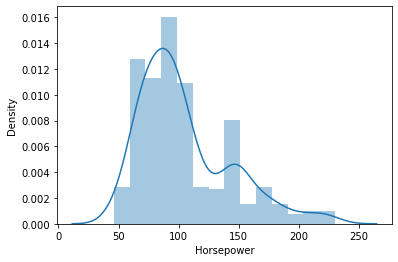

In [10]:
df["Horsepower"] = df["Horsepower"].fillna(df["Horsepower"].mean())
sns.distplot(df["Horsepower"]);

In [11]:
df.isna().sum()

target          0
Cylinders       0
Displacement    0
Horsepower      0
weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

# EDA

In [12]:
corr_matrix = df.corr()

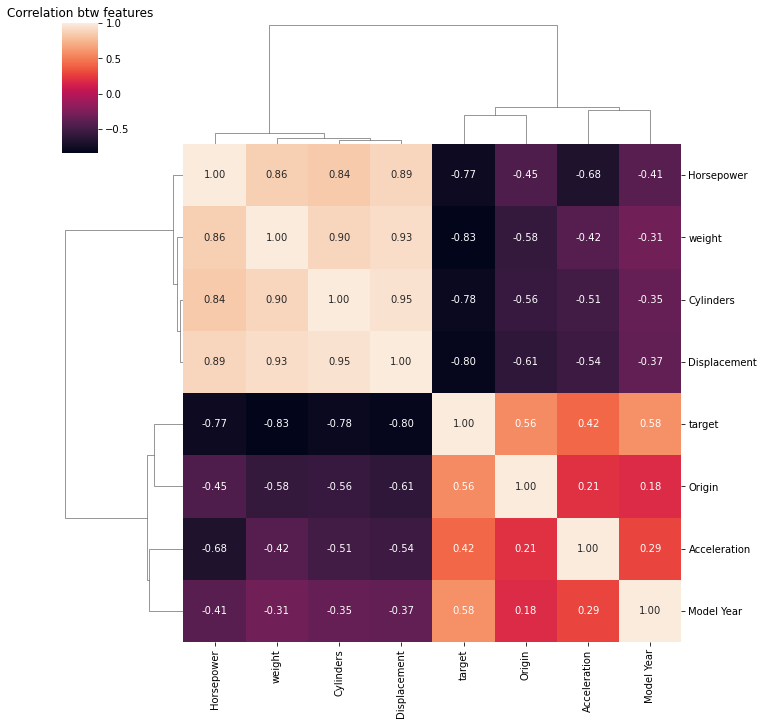

In [13]:
sns.clustermap(corr_matrix,annot = True, fmt =".2f")
plt.title("Correlation btw features")
plt.show()

* threshold 0.75 üzeri olan featurlerı görebilmek için. pairplotta kolay göreyim ve korelasyon matrisimi küçültmek için yapıyorum.

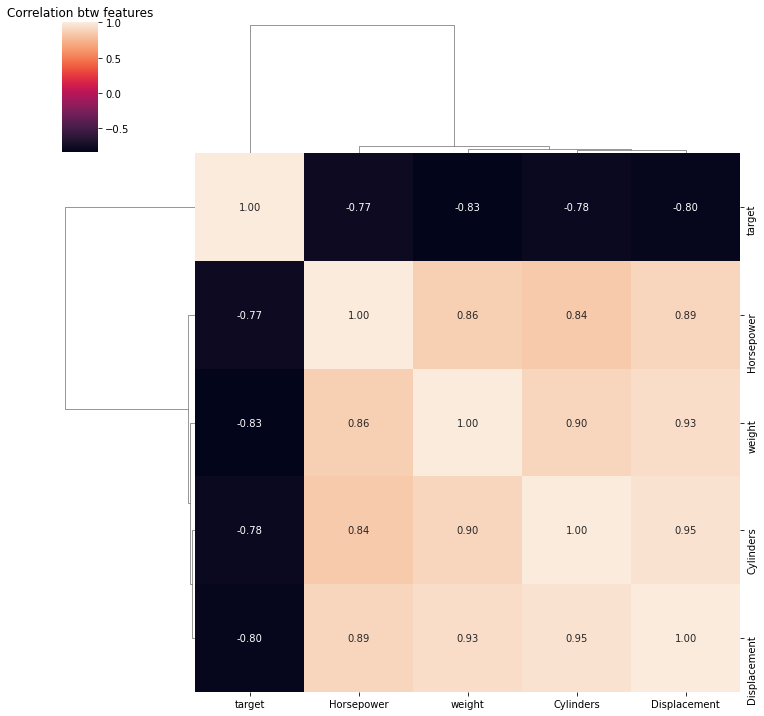

In [14]:
threshold = 0.75
filtre = np.abs(corr_matrix["target"])> threshold
corr_feature = corr_matrix.columns[filtre].tolist()

sns.clustermap(df[corr_feature].corr(),annot = True, fmt =".2f")
plt.title("Correlation btw features")
plt.show()

* Birbirleri ile  ilişkili birden fazla featureın yani 1 yerine 5 tane feature aynı şeyi söylüyorsa modelimi yanlış yönlendirebilir. 1 tanesi yetiyorsa 5 tanesinin kullanmaya gerek yok. Yani burada **multicollinearity** söz konusu. 

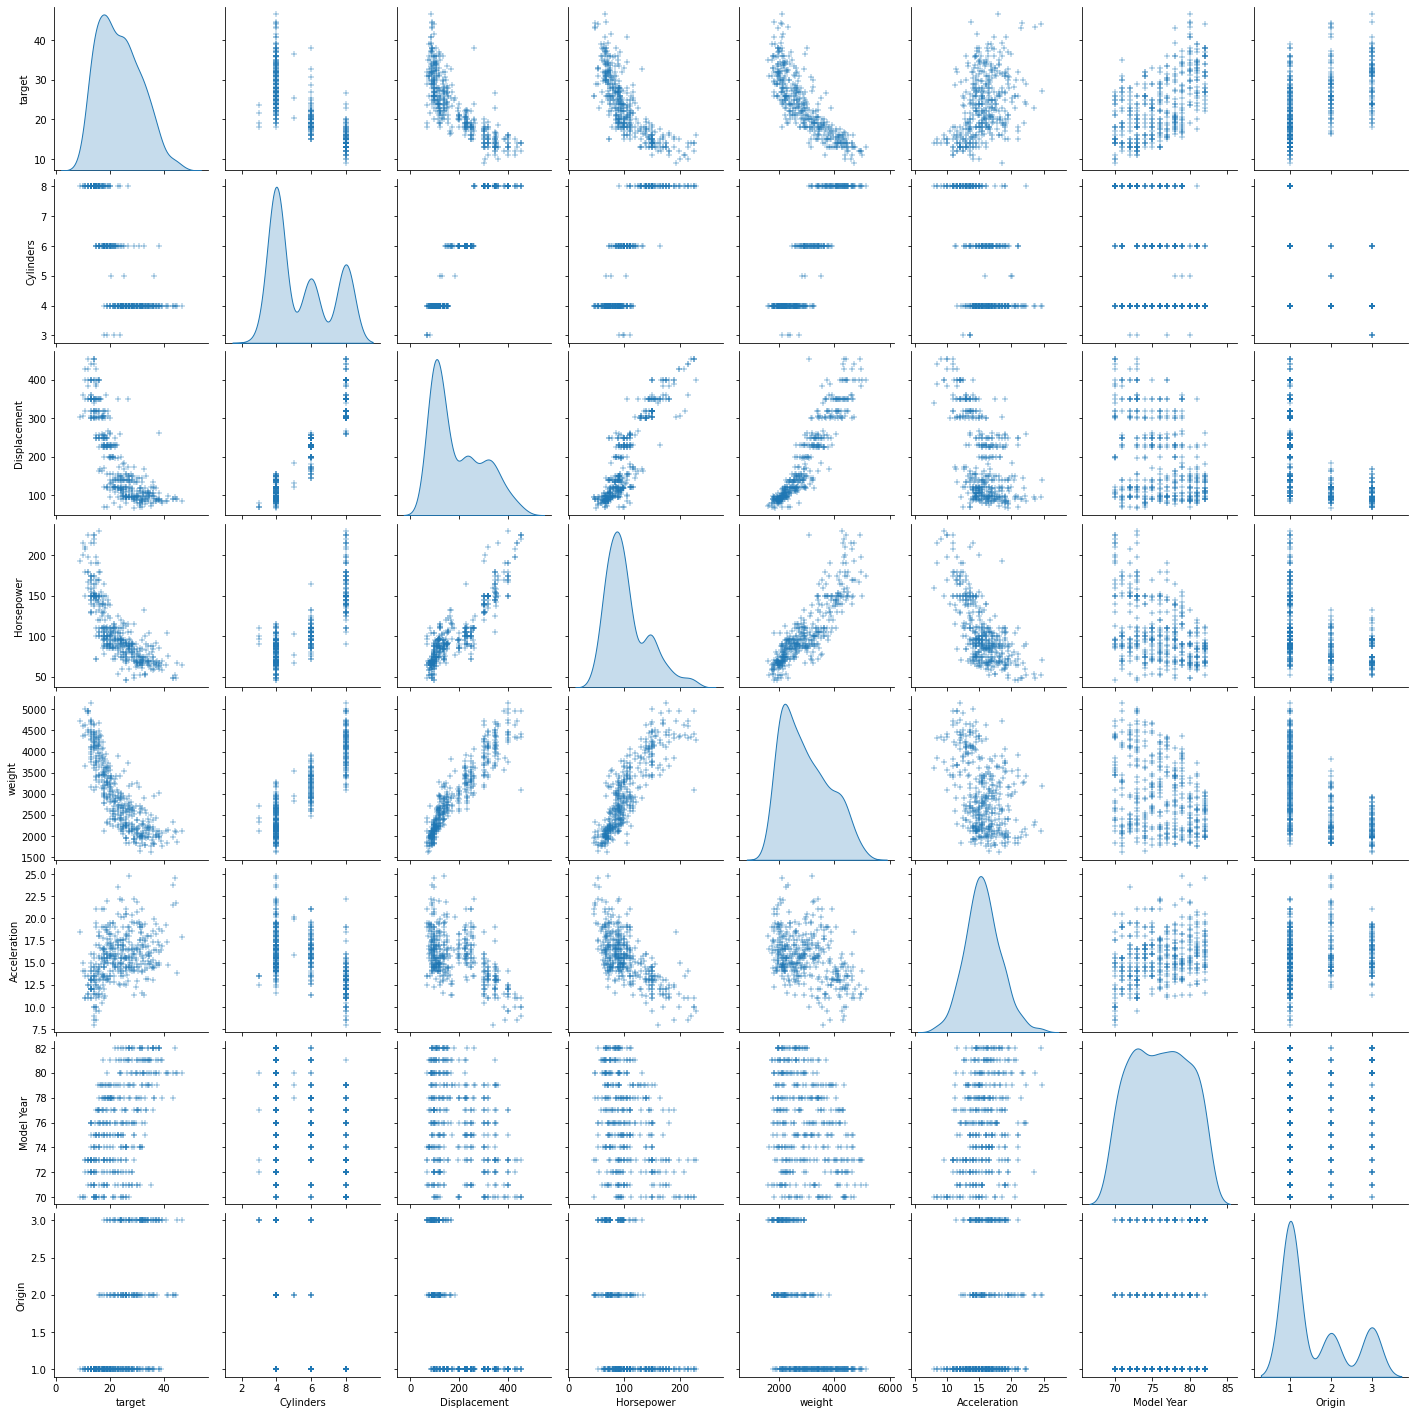

In [15]:
sns.pairplot(df,diag_kind = "kde", markers = "+")
plt.show()

## Outlier

* silindir ve origin featurlarını kategorik olarak düşünebilirim.

4    204
8    103
6     84
3      4
5      3
Name: Cylinders, dtype: int64

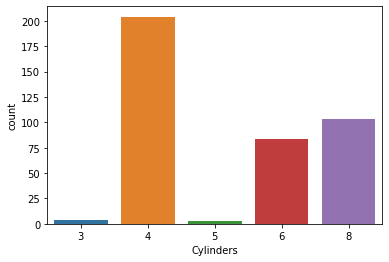

In [16]:
plt.figure()
sns.countplot(df["Cylinders"]);
df["Cylinders"].value_counts()

1    249
3     79
2     70
Name: Origin, dtype: int64

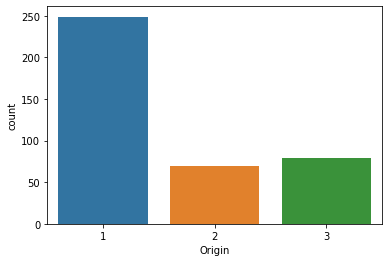

In [17]:
plt.figure()
sns.countplot(df["Origin"]);
df["Origin"].value_counts()

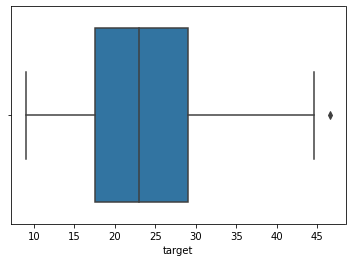

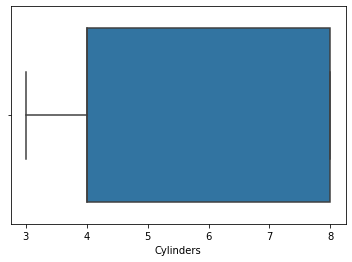

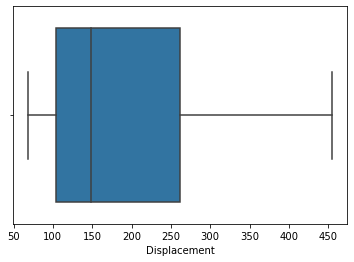

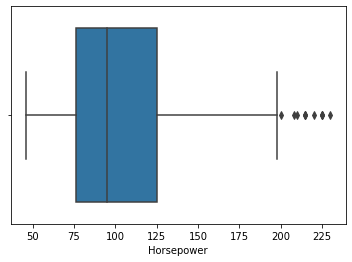

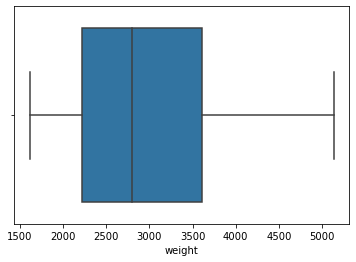

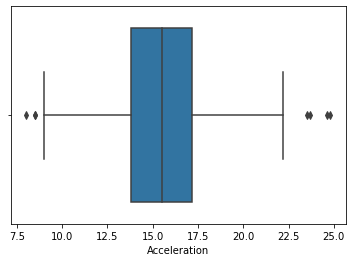

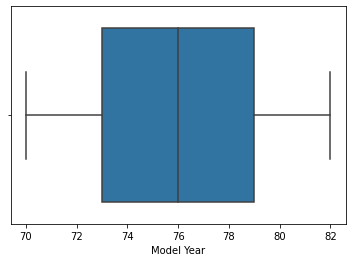

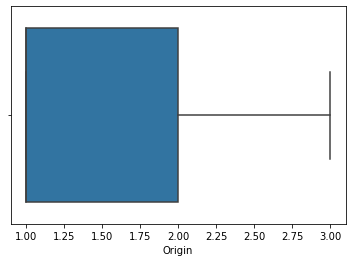

In [18]:
#box
for c in df.columns:
    plt.figure()
    sns.boxplot(x = c, data =df, orient="v");

* Outlier : horsepower ve acceleration kolonlarında ki aykırı degerleri çıkarıcam.

In [19]:
horsepower_desc =df["Horsepower"].describe()
horsepower_desc

count    398.000000
mean     104.469388
std       38.199187
min       46.000000
25%       76.000000
50%       95.000000
75%      125.000000
max      230.000000
Name: Horsepower, dtype: float64

In [20]:
threshold = 2
q3_hp= horsepower_desc[6]
q1_hp = horsepower_desc[4]
IQR_hp = q3_hp - q1_hp

top_limit_hp = q3_hp + threshold * IQR_hp
bottom_limit_hp = q1_hp - threshold * IQR_hp

filter_hp_bottom = bottom_limit_hp < df["Horsepower"]
filter_hp_top = top_limit_hp > df["Horsepower"]

filter_hp = filter_hp_bottom & filter_hp_top

df = df[filter_hp]

In [21]:
df.shape

(394, 8)

In [22]:
acceleration_desc =df["Acceleration"].describe()
acceleration_desc

count    394.000000
mean      15.623350
std        2.715625
min        8.000000
25%       14.000000
50%       15.500000
75%       17.200000
max       24.800000
Name: Acceleration, dtype: float64

In [23]:
q3_hp= acceleration_desc[6]
q1_hp = acceleration_desc[4]
IQR_hp = q3_hp - q1_hp

top_limit_hp = q3_hp + threshold * IQR_hp
bottom_limit_hp = q1_hp - threshold * IQR_hp

filter_hp_bottom = bottom_limit_hp < df["Acceleration"]
filter_hp_top = top_limit_hp > df["Acceleration"]

filter_hp = filter_hp_bottom & filter_hp_top

df = df[filter_hp]

In [24]:
df.shape

(391, 8)

* Toplamda 7 tane aykırı değerden kurtulmuş oldum

# Feature Engineering

In [25]:
#skewness' a bakıcam

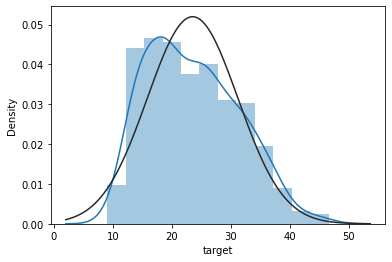

In [26]:
#target kolonuma bakıyorum.
sns.distplot(df["target"], fit = norm);

In [27]:
(mu,sigma) = norm.fit(df["target"])
print(f"mu: {mu}, sigma: {sigma}")

mu: 23.499232736572893, sigma: 7.678599778082707


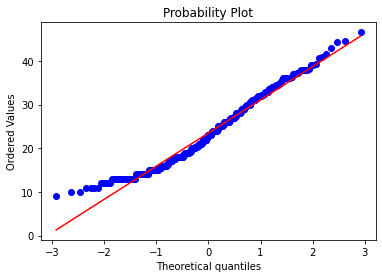

In [28]:
# qq plot
plt.figure()
stats.probplot(df["target"], plot = plt)
plt.show()


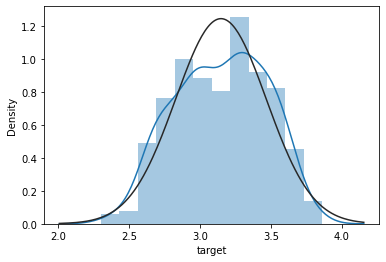

In [29]:
# skewness değerini yani çarpıklığı azaltmak için log transformasyon yapıcam
df["target"] = np.log1p(df["target"])
plt.figure()
sns.distplot(df["target"], fit = norm);

In [30]:
(mu,sigma) = norm.fit(df["target"])
print(f"mu: {mu}, sigma: {sigma}")

mu: 3.148549778053243, sigma: 0.31986792768696354


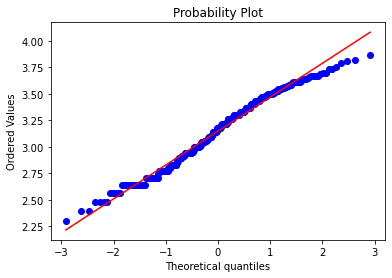

In [31]:
# qq plot
plt.figure()
stats.probplot(df["target"], plot = plt)
plt.show()

* target kolonumu düzelttim.

In [32]:
# feature independent variable
skewed_feats = df.apply(lambda x: skew(x.dropna())).sort_values(ascending= False)
skewness = pd.DataFrame(skewed_feats, columns = ["skewed"])
skewness.head()

,skewed
Horsepower,1.002620
Origin,0.915147
Displacement,0.692506
Cylinders,0.539419
weight,0.530167


* Horsepower da pozitif skewness var. Çünkü 1 den büyük
* negatif skewness yok. Çünkü -1 den küçük değer yok

* featurlarımda skewnesslık varsa ; Box Cox Transformation ile skewness değerlerini düzeltebilirim.

**OneHotEncoding**

In [33]:
df["Cylinders"] = df["Cylinders"].astype(str)
df["Origin"] = df["Origin"].astype(str)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 391 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   target        391 non-null    float64
 1   Cylinders     391 non-null    object 
 2   Displacement  391 non-null    float64
 3   Horsepower    391 non-null    float64
 4   weight        391 non-null    float64
 5   Acceleration  391 non-null    float64
 6   Model Year    391 non-null    int64  
 7   Origin        391 non-null    object 
dtypes: float64(5), int64(1), object(2)
memory usage: 27.5+ KB


In [35]:
df = pd.get_dummies(df)
df.head()

,target,Displacement,Horsepower,weight,Acceleration,Model Year,Cylinders_3,Cylinders_4,Cylinders_5,Cylinders_6,Cylinders_8,Origin_1,Origin_2,Origin_3
0,2.944439,307.0,130.0,3504.0,12.0,70,0,0,0,0,1,1,0,0
1,2.772589,350.0,165.0,3693.0,11.5,70,0,0,0,0,1,1,0,0
2,2.944439,318.0,150.0,3436.0,11.0,70,0,0,0,0,1,1,0,0
3,2.833213,304.0,150.0,3433.0,12.0,70,0,0,0,0,1,1,0,0
4,2.890372,302.0,140.0,3449.0,10.5,70,0,0,0,0,1,1,0,0


# Split - Stand

In [36]:
y = df["target"]
X= df.drop(["target"],axis = 1)

In [37]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size =0.9, random_state = 42)

In [38]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(39, 13) (352, 13) (39,) (352,)


In [39]:
#standartization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

* mean 0, standart sapması 1 e ayarlamış oldum.

## Regression Models

# Linear Regression

In [64]:
lr = LinearRegression()
lr.fit(X_train,y_train)
print("LR Coef: ",lr.coef_)
y_pred = lr.predict(X_test)
lin_mse = mean_squared_error(y_test,y_pred)
print("Linear Regression MSE: ", lin_mse)

LR Coef:  [-0.12110124 -0.04555804 -0.05953953 -0.0481553   0.09419335  0.
  0.00514635 -0.02470095  0.00237915  0.00674877 -0.01462858  0.02221117
 -0.00883751]
Linear Regression MSE:  0.017803776531038408


# Regularization

* Regularization tekniği: overfiti engellememizi sağlayan teniktir. Varyansı azaltmaya yarar.

# Ridge Regression (L2)

In [65]:
ridge = Ridge(random_state=42, max_iter = 10000)
alphas = np.logspace(-4,-0.5,30)
tuned_parameters = [{"alpha":alphas}]
n_fold = 5
clf= GridSearchCV(ridge,tuned_parameters,cv = n_fold,scoring ="neg_mean_squared_error",refit = True)
#refit False olursa başka yerde clf yi kullanamam
clf.fit(X_train,y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Ridge Coef: ",clf.best_estimator_.coef_)
ridge = clf.best_estimator_

print("Ridge Best Estimator: ",ridge)
y_pred = clf.predict(X_test)
ridge_mse = mean_squared_error(y_test,y_pred)
print("Ridge MSE: ",ridge_mse)

Ridge Coef:  [-0.10285747 -0.04596053 -0.06532809 -0.04703368  0.09401689  0.
  0.01082148 -0.02307721 -0.00116098  0.00097552 -0.01534303  0.02275077
 -0.0084845 ]
Ridge Best Estimator:  Ridge(alpha=0.31622776601683794, max_iter=10000, random_state=42)
Ridge MSE:  0.017051767371789484


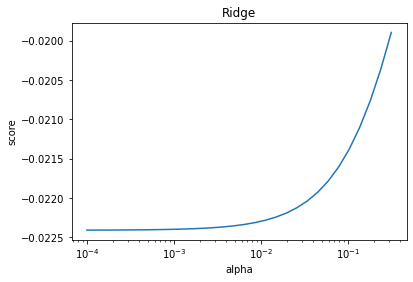

In [66]:
plt.figure()
plt.semilogx(alphas,scores) #logspace ile yaratmıştım alphayı bu yüzden çizdirirkende logspace kullanmam gerekti.
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Ridge")
plt.show()

# Lasso Regression

In [67]:
lasso = Lasso(random_state=42, max_iter = 10000)
alphas = np.logspace(-4,-0.5,30)
tuned_parameters = [{"alpha":alphas}]
n_fold = 5
clf= GridSearchCV(lasso,tuned_parameters,cv = n_fold,scoring ="neg_mean_squared_error",refit = True)
#refit False olursa başka yerde clf yi kullanamam
clf.fit(X_train,y_train)
scores = clf.cv_results_["mean_test_score"]
scores_std = clf.cv_results_["std_test_score"]

print("Lasso Coef: ",clf.best_estimator_.coef_)

lasso = clf.best_estimator_
print("Lasso Best Estimator: ",lasso)

y_pred = clf.predict(X_test)
las_mse = mean_squared_error(y_test,y_pred)
print("Lasso MSE: ",las_mse)

Lasso Coef:  [-0.11896842 -0.         -0.08103413 -0.01166124  0.07100283  0.
  0.00304688 -0.         -0.         -0.         -0.          0.
  0.        ]
Lasso Best Estimator:  Lasso(alpha=0.0196382800192977, max_iter=10000, random_state=42)
Lasso MSE:  0.016520105807564


* Lasso gereksiz featurlara direkt sıfır değerini atıyor, sadece gereklileri kullanıyor.

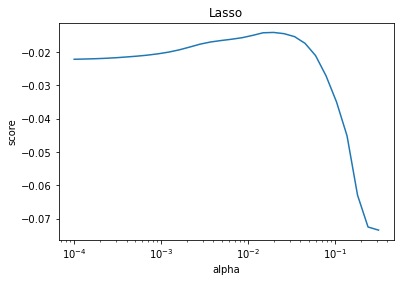

In [68]:
plt.figure()
plt.semilogx(alphas,scores) #logspace ile yaratmıştım alphayı bu yüzden çizdirirkende logspace kullanmam gerekti.
plt.xlabel("alpha")
plt.ylabel("score")
plt.title("Lasso")
plt.show()

# ElasaticNet

In [69]:
parametersGrid = {"alpha":alphas,
                 "l1_ratio":np.arange(0.0,1.0,0.05)}

eNet = ElasticNet(random_state = 42, max_iter = 10000)
clf= GridSearchCV(eNet,parametersGrid,cv = n_fold, scoring ="neg_mean_squared_error",refit = True)
clf.fit(X_train,y_train)

print("ElasticNet Coef: ",clf.best_estimator_.coef_)


eNet = clf.best_estimator_
print("Lasso Best Estimator: ",eNet)

y_pred = clf.predict(X_test)
elastic_mse = mean_squared_error(y_test,y_pred)
print("ElasticNet MSE: ",elastic_mse)

ElasticNet Coef:  [-0.06677399 -0.03329352 -0.06777475 -0.03014659  0.07455473  0.
  0.0392998  -0.00073448 -0.         -0.01057325 -0.00872815  0.01347745
  0.        ]
Lasso Best Estimator:  ElasticNet(alpha=0.1373823795883264, l1_ratio=0.05, max_iter=10000,
           random_state=42)
ElasticNet MSE:  0.014937926405166658


In [76]:
mse = {"Linear Regression":lin_mse,"Ridge Regression":ridge_mse,"Lasso Regression":las_mse,"ElasticNet Regression":elastic_mse}
for i in mse.items():
    print(i)

('Linear Regression', 0.017803776531038408)
('Ridge Regression', 0.017051767371789484)
('Lasso Regression', 0.016520105807564)
('ElasticNet Regression', 0.014937926405166658)


* En iyi sonuca ElasticNet regression ile ulaştım.